## Resnet with memory

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Layer, Input, Flatten, concatenate, Lambda, ZeroPadding2D, MaxPool2D, AveragePooling2D
import tensorflow_datasets as tfds
import numpy as np
import math
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Adding Memory to resnet50

In [ ]:
def find_closest_perfect_square(n):
    i = n**0.5
    if i%1 !=0: i = int(i)+1
    else: i = int(i)
    return (i*i, i)

In [ ]:
memory_channels = 1024
memory_shape = (7, 7, memory_channels)
total_m = memory_shape[0] * memory_shape[1] * memory_shape[2]
closest_perfect_square = find_closest_perfect_square(total_m)
memory_input = Input(shape = memory_shape)
Memory = Conv2D(memory_channels, (1,1), activation='linear')(memory_input)

In [ ]:
total_m, closest_perfect_square

(50176, (50176, 224))

In [ ]:
def memory_reshape_block(memory, target_shape, mem_shape, closest_perfect_square = closest_perfect_square):
    p_sq, sq = closest_perfect_square
    _, n_rows, n_cols, n_c = target_shape #14, 14, 1
    m_rows, m_cols, m_c = mem_shape #7, 7, 6
    
    total_m = m_rows * m_cols * m_c #minimum total space for memory # 294
    total_t = n_rows * n_cols  #total space in target #196

    if n_rows > sq: 

        x = layers.Reshape((total_m, 1))(memory)
        x = layers.ZeroPadding1D(padding = (p_sq - total_m)//2)(x)
        x = layers.Reshape((sq, sq, 1))(x)
        x = layers.ZeroPadding2D(padding = (n_rows - sq)//2 )(x)
        return x
    
    if total_t < total_m: 
        buckets = total_m//(n_rows*n_rows)
        x = layers.Reshape((n_rows, n_cols, buckets))(memory)
        return x

In [ ]:
def memory_update_block(input_tensor, memory_shape, Memory, filters, kernel_size, stage, block):
    
    filters1, filters2, filters3 = filters
    bn_axis = 3

    memory_name_base = 'Memory' + str(stage) + block + '_branch'
    memory_pad_base = 'mem_pad' + str(stage) + block + '_branch'
    concat_name_base = 'mem_concat' + str(stage) + block + '_branch'
    conv_name_base = 'mem_conv' + str(stage) + block + '_branch'
    pool_name_base = 'mem_pool' + str(stage) + block + '_branch'
    bn_name_base = 'mem_bn' + str(stage) + block + '_branch'

    _, n_rows, n_cols, n_c = input_tensor.shape #224, 224, 3
    m_rows, m_cols, m_c = memory_shape # 7, 7, 3

    memory_pad = memory_reshape_block(Memory, input_tensor.shape, memory_shape)

    concat = concatenate([input_tensor, memory_pad], name = concat_name_base) # 56 x 56 x 129

    x = Conv2D(filters = filters1, kernel_size = kernel_size, 
                           padding = 'same', kernel_initializer='he_normal', 
                           name = conv_name_base + '_a')(concat) 
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '_2a')(x)
    x = layers.Activation('sigmoid')(x)

    x = Conv2D(filters = filters2, kernel_size = kernel_size,
                           padding = 'same', kernel_initializer='he_normal', 
                           name = conv_name_base + '_b')(x) 
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '_2b')(x)
    x = layers.Activation('sigmoid')(x)

    x = Conv2D(filters = filters3, kernel_size = kernel_size, padding = 'same',
                           kernel_initializer='he_normal',
                           name = conv_name_base + '_c')(x) 
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '_2c')(x)
    x = layers.Activation('sigmoid')(x)

    factor = (n_rows//m_rows, n_cols//m_cols)
    x = AveragePooling2D(pool_size=factor,strides=factor)(x)
    Memory = Conv2D(filters=m_c, kernel_size=(1, 1), strides=(1,1), padding='same', name = memory_name_base)(x) 
    return Memory

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block, memory, memory_shape=memory_shape):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    
    memory_name_base = 'memory' + str(stage) + block + '_branch'
    memory_pad_base = 'memory_pad' + str(stage) + block + '_branch'
    concat_name_base = 'concat' + str(stage) + block + '_branch'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    bn_axis = 3
    
    memory_pad = memory_reshape_block(Memory, input_tensor.shape, memory_shape)
                                      
    concat = layers.concatenate([input_tensor, memory_pad])

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(concat)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor,kernel_size,
               filters,stage,block,memory,
               strides=(2, 2),
               memory_shape=memory_shape):

    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3

    memory_name_base = 'memory' + str(stage) + block + '_branch'
    memory_pad_base = 'memory_pad' + str(stage) + block + '_branch'
    concat_name_base = 'concat' + str(stage) + block + '_branch'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    memory_pad = memory_reshape_block(memory, input_tensor.shape, memory_shape)                                  
    concat = layers.concatenate([input_tensor, memory_pad], name = concat_name_base)

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(concat)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet50(include_top=True,
             input_shape=None,
             memory_input=None,
             classes=100,
             **kwargs):

    img_input = layers.Input(shape=input_shape, name = 'image_input')
    bn_axis = 3

    MEMORY = Conv2D(memory_channels, (1,1), activation='linear', name='mem_init')(memory_input)

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(1, 1),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)


    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), memory = MEMORY)
    MEMORY = memory_update_block(x, memory_shape, MEMORY, [16, 16, 32], (3,3), stage=2, block='a')

    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', memory = MEMORY)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', memory = MEMORY)
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', memory = MEMORY)
    MEMORY = memory_update_block(x, memory_shape, MEMORY, [16, 16, 32], (3,3), stage=3, block='a')

    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', memory = MEMORY)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', memory = MEMORY)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', memory = MEMORY)
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', memory = MEMORY)
    MEMORY = memory_update_block(x, memory_shape, MEMORY, [16, 16, 32], (3,3), stage=4, block='a')

    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', memory = MEMORY)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', memory = MEMORY)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', memory = MEMORY)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', memory = MEMORY)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', memory = MEMORY)
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', memory = MEMORY)
    MEMORY = memory_update_block(x, memory_shape, MEMORY, [16, 16, 32], (3,3), stage=5, block='a')

    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', memory = MEMORY)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', memory = MEMORY)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    inputs = [img_input, memory_input]
    # Create model.
    model = tf.keras.Model(inputs, x, name='resnet50')

    return model

In [ ]:
#model = ResNet50(include_top=True, input_shape=(224,224,3), classes=NUM_CLASSES, memory_input=memory_input)

Number of parameters increase by around a 3 million

In [ ]:
#plot_model(model, show_shapes=True,expand_nested = True)

In [ ]:
#len(model.layers)

### To Train ResNet on Memory

In [ ]:
memory_channels = 1024
memory_shape = (7, 7, memory_channels)
total_m = memory_shape[0] * memory_shape[1] * memory_shape[2]
closest_perfect_square = find_closest_perfect_square(total_m)
memory_input = Input(shape = memory_shape)
Memory = Conv2D(memory_channels, (1,1), activation='linear')(memory_input)

In [ ]:
import tensorflow_datasets as tfds

batch_size = 16

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train", "test"], with_info=True, as_supervised=True)
NUM_CLASSES = ds_info.features["label"].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0Z2QDD/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0Z2QDD/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

mem_inp = np.ones((memory_shape))

ds_train = ds_train.map(input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train  = ds_train.map(lambda img, label: ((img, mem_inp), label))
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.map(lambda img, label: ((img, mem_inp), label))
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

### Training after adding more Memory

In [ ]:
for data in ds_train:
    print(data[0][0].shape)
    print(data[0][1].shape)
    print(data[1].shape)
    break

(16, 224, 224, 3)
(16, 7, 7, 1024)
(16, 120)


In [ ]:
for data in ds_test:
    print(data[0][0].shape)
    print(data[0][1].shape)
    print(data[1].shape)
    break

(16, 224, 224, 3)
(16, 7, 7, 1024)
(16, 120)


In [ ]:
def build_memory_model(num_classes):
    inputs = [Input(shape = (IMG_SIZE, IMG_SIZE, 3)), Input(shape = (memory_shape))]
    input0 = img_augmentation(inputs[0])

    memory_resnet = ResNet50(include_top=True, input_shape=(224,224,3), classes=NUM_CLASSES, memory_input=memory_input)

    outputs = memory_resnet([input0, inputs[1]])
    
    #compiling model
    model = tf.keras.Model(inputs, outputs, name = f'memory_resnet_{memory_channels}_model')
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


model = build_memory_model(num_classes=NUM_CLASSES)

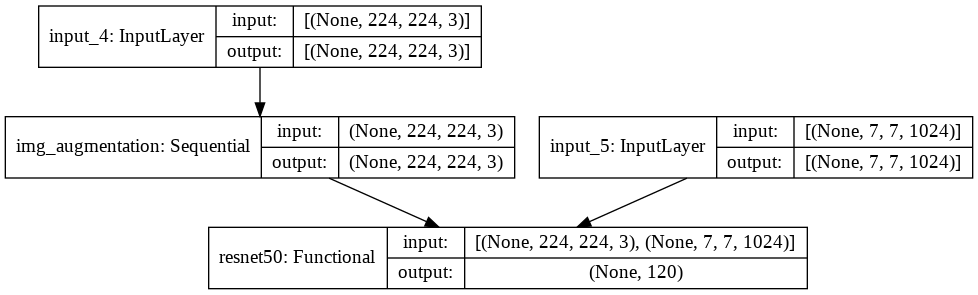

In [ ]:
plot_model(model, f'memory_resnet_{memory_channels}.png', show_shapes=True, expand_nested=False)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=7, restore_best_weights=True, verbose = 1, min_delta = 0.001)
mc = tf.keras.callbacks.ModelCheckpoint(f'memory_resnet_{memory_channels}_model.h5', save_weights_only=True, monitor='val_accuracy', verbose = 1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose = 1, min_delta=0.0001)

Training time per epoch increased from 3mins to 6 mins

In [ ]:
history = model.fit(ds_train, epochs = 50, callbacks=[es, mc, rlr], validation_data=ds_test)

Epoch 1/50
750/750 [==============================] - 329s 438ms/step - loss: 4.8556 - accuracy: 0.0092 - val_loss: 4.9878 - val_accuracy: 0.0105

Epoch 00001: saving model to memory_resnet_1024_model.h5
Epoch 2/50
750/750 [==============================] - 327s 437ms/step - loss: 4.6809 - accuracy: 0.0179 - val_loss: 4.6174 - val_accuracy: 0.0234

Epoch 00002: saving model to memory_resnet_1024_model.h5
Epoch 3/50
750/750 [==============================] - 328s 437ms/step - loss: 4.5991 - accuracy: 0.0227 - val_loss: 4.5134 - val_accuracy: 0.0275

Epoch 00003: saving model to memory_resnet_1024_model.h5
Epoch 4/50
750/750 [==============================] - 328s 437ms/step - loss: 4.5117 - accuracy: 0.0308 - val_loss: 4.4403 - val_accuracy: 0.0321

Epoch 00004: saving model to memory_resnet_1024_model.h5
Epoch 5/50
750/750 [==============================] - 328s 437ms/step - loss: 4.4552 - accuracy: 0.0337 - val_loss: 4.4689 - val_accuracy: 0.0289

Epoch 00005: saving model to memory_r

In [ ]:
!cp memory_resnet_1024_model.h5 '/content/drive/MyDrive/Colab Notebooks/Computer Vision'

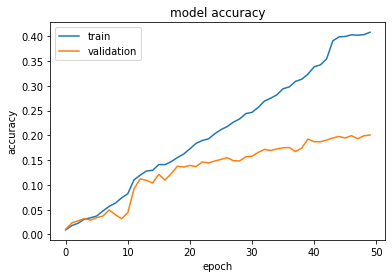

In [ ]:
plot_hist(history)

In [ ]:
for layer in model.layers[3].layers:
    print(layer.name, " --> ", layer.input_shape , "-->" , layer.output_shape)

image_input  -->  [(None, 224, 224, 3)] --> [(None, 224, 224, 3)]
conv1_pad  -->  (None, 224, 224, 3) --> (None, 230, 230, 3)
conv1  -->  (None, 230, 230, 3) --> (None, 224, 224, 64)
bn_conv1  -->  (None, 224, 224, 64) --> (None, 224, 224, 64)
activation  -->  (None, 224, 224, 64) --> (None, 224, 224, 64)
input_3  -->  [(None, 7, 7, 1024)] --> [(None, 7, 7, 1024)]
pool1_pad  -->  (None, 224, 224, 64) --> (None, 226, 226, 64)
mem_init  -->  (None, 7, 7, 1024) --> (None, 7, 7, 1024)
max_pooling2d  -->  (None, 226, 226, 64) --> (None, 112, 112, 64)
reshape  -->  (None, 7, 7, 1024) --> (None, 112, 112, 4)
concat2a_branch  -->  [(None, 112, 112, 64), (None, 112, 112, 4)] --> (None, 112, 112, 68)
res2a_branch2a  -->  (None, 112, 112, 68) --> (None, 112, 112, 64)
bn2a_branch2a  -->  (None, 112, 112, 64) --> (None, 112, 112, 64)
activation_1  -->  (None, 112, 112, 64) --> (None, 112, 112, 64)
res2a_branch2b  -->  (None, 112, 112, 64) --> (None, 112, 112, 64)
bn2a_branch2b  -->  (None, 112, 112

In [ ]:
layers = model.layers[3].layers

In [ ]:
for layer in layers:
    if layer.name == 'mem_init':
        print(layer.weights)
    if layer.name == 'conv2d_2':
        print(layer.weights)

[<tf.Variable 'mem_init/kernel:0' shape=(1, 1, 1024, 1024) dtype=float32, numpy=
array([[[[ 0.01175822, -0.06059385,  0.08348525, ..., -0.04077558,
          -0.05095734, -0.00044284],
         [ 0.02194061,  0.02498219,  0.00451677, ..., -0.03824757,
           0.01581497,  0.01803164],
         [ 0.05711469, -0.00937291,  0.08278073, ...,  0.00807504,
          -0.06822142,  0.04381056],
         ...,
         [ 0.01814414,  0.03029152,  0.05014874, ..., -0.07822615,
           0.00363351,  0.05491984],
         [-0.03882923, -0.03777824,  0.06055531, ...,  0.00611774,
          -0.07369368,  0.07440451],
         [-0.02086979, -0.00985445,  0.05233872, ..., -0.0050148 ,
          -0.0383048 , -0.01718811]]]], dtype=float32)>, <tf.Variable 'mem_init/bias:0' shape=(1024,) dtype=float32, numpy=
array([ 0.00440115, -0.02356605,  0.0557481 , ..., -0.02839257,
       -0.02448971,  0.03406415], dtype=float32)>]
[<tf.Variable 'conv2d_2/kernel:0' shape=(1, 1, 1024, 1024) dtype=float32, numpy

In [ ]:
import pickle

In [ ]:
with open(f'memory_resnet_{memory_channels}_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
!cp '/content/memory_resnet_1024_history.pickle' '/content/drive/MyDrive/Colab Notebooks/Computer Vision'

In [ ]:
with open(f'memory_resnet_{memory_channels}_history.pickle', 'rb') as f:
    h = pickle.load(f)

In [ ]:
def plot_pickled_hist(hist):
    plt.plot(hist["accuracy"])
    plt.plot(hist["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_pickled_hist(h)